In [943]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [944]:
df = pd.read_csv("train_dataset.csv")
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


In [945]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18137 entries, 0 to 18136
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          18137 non-null  int64  
 1   no_of_children                        18137 non-null  int64  
 2   no_of_weekend_nights                  18137 non-null  int64  
 3   no_of_week_nights                     18137 non-null  int64  
 4   type_of_meal_plan                     18137 non-null  int64  
 5   required_car_parking_space            18137 non-null  int64  
 6   room_type_reserved                    18137 non-null  int64  
 7   lead_time                             18137 non-null  int64  
 8   arrival_year                          18137 non-null  int64  
 9   arrival_month                         18137 non-null  int64  
 10  arrival_date                          18137 non-null  int64  
 11  market_segment_

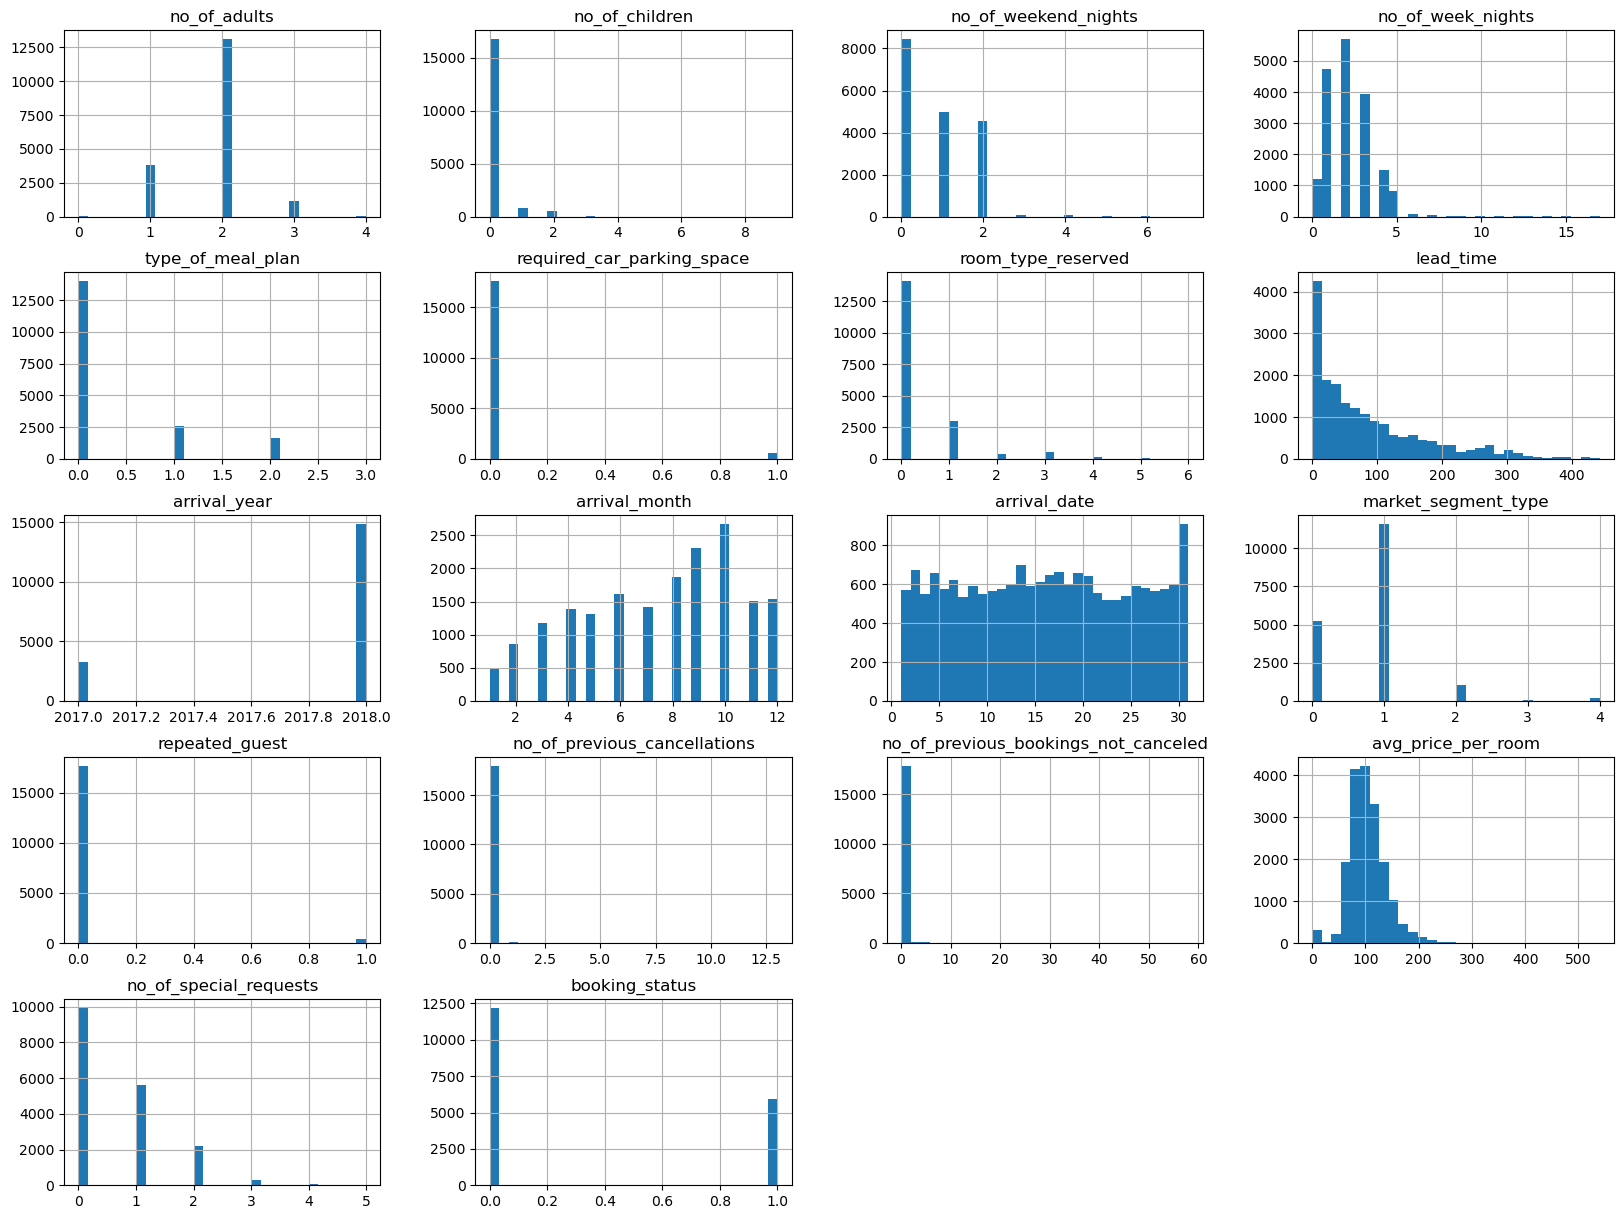

In [946]:
df.hist(bins=30, figsize=(20,15))
plt.show()

In [947]:
df = df[df["avg_price_per_room"] != 0].copy()

In [948]:
(df["lead_time"] == 0).sum()

np.int64(584)

In [949]:
anzahl = ((df["lead_time"] == 0) & (df["booking_status"] == 1)).sum()
print("lead_time=0 und storniert:", anzahl)

lead_time=0 und storniert: 33


In [950]:
#Bucketizing
df["n_lead_time"] = pd.cut(df["lead_time"],bins=[-0.5, 7, 30, 90, np.inf],labels=[0, 1, 2, 3]).astype(int)

In [951]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["booking_status"])   # Features
y = df["booking_status"]                  # Zielvariable

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=df["booking_status"], random_state=42)


In [952]:
corr_view = Xtrain.copy()

In [953]:
corr_view.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14282 entries, 6099 to 7239
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14282 non-null  int64  
 1   no_of_children                        14282 non-null  int64  
 2   no_of_weekend_nights                  14282 non-null  int64  
 3   no_of_week_nights                     14282 non-null  int64  
 4   type_of_meal_plan                     14282 non-null  int64  
 5   required_car_parking_space            14282 non-null  int64  
 6   room_type_reserved                    14282 non-null  int64  
 7   lead_time                             14282 non-null  int64  
 8   arrival_year                          14282 non-null  int64  
 9   arrival_month                         14282 non-null  int64  
 10  arrival_date                          14282 non-null  int64  
 11  market_segment_typ

In [954]:
def binarize_features(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df["n_" + col] = (df[col] > 0).astype(int)
        else:
            print(f"{col} nicht gefunden")
    return df


In [955]:
# Umwandlung Binär: 0 = kein Wochenende 1=Wochenende
#corr_view["n_is_weekend"] = (corr_view["no_of_weekend_nights"] > 0).astype(int)
#corr_view["n_was_cancelled"] = (corr_view["no_of_previous_cancellations"] > 0).astype(int)
#corr_view["n_is_familie"] = (corr_view["no_of_children"] > 0).astype(int)
#corr_view["n_room_type_bin"] = (corr_view["room_type_reserved"] != 0).astype(int)

corr_view=binarize_features(corr_view, ["no_of_weekend_nights","no_of_previous_cancellations","no_of_children","room_type_reserved"])

In [956]:

corr_view["n_cut_special_request"] = pd.cut(corr_view["no_of_special_requests"],  bins=[-0.5,0.5,1.5,np.inf], labels=[0,1,2]).astype(int)

# 0 | 1 | 2-4
corr_view["n_market_segment_bin"] = pd.cut(corr_view["market_segment_type"],bins=[-0.5, 0.5, 1.5, np.inf],labels=[0, 1, 2],include_lowest=True).astype(int)

# Winter, Frühling, Sommer, Herbst, Winter # 5 Intervalle → 5 Labels
corr_view["n_arrival_season"] = pd.cut(corr_view["arrival_month"],bins=[0,3,6,9,12],labels=[1, 2, 3, 4],include_lowest=True).astype(int)


#Entlastung avg_price_per_room
corr_view["n_avg_price_per_room"] = np.log10(corr_view["avg_price_per_room"])

# 0 = sehr kurzfristig, 1 = kurzfristig, 2 = mittelfristig, 3 = langfristig
#Bucketizing
#corr_view["n_lead_time"] = pd.cut(corr_view["lead_time"],bins=[-0.5, 7, 30, 90, np.inf],labels=[0, 1, 2, 3]).astype(int)


"""corr_view = corr_view[["n_lead_time",
                       "n_is_weekend",
                       "n_room_type_bin",
                       "n_is_familie",
                       "n_arrival_season",
                       "n_market_segment_bin",
                       "n_was_cancelled",
                       "n_cut_special_request"]]
"""                

'corr_view = corr_view[["n_lead_time",\n                       "n_is_weekend",\n                       "n_room_type_bin",\n                       "n_is_familie",\n                       "n_arrival_season",\n                       "n_market_segment_bin",\n                       "n_was_cancelled",\n                       "n_cut_special_request"]]\n'

In [957]:
corr_view["booking_status"] = ytrain
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status                          1.000000
lead_time                               0.425968
n_lead_time                             0.360958
arrival_year                            0.178806
n_avg_price_per_room                    0.135950
avg_price_per_room                      0.123786
no_of_week_nights                       0.095746
no_of_adults                            0.087191
type_of_meal_plan                       0.076321
no_of_weekend_nights                    0.049710
n_no_of_weekend_nights                  0.039199
no_of_children                          0.030014
n_room_type_reserved                    0.028772
room_type_reserved                      0.026241
n_no_of_children                        0.024913
arrival_date                            0.010159
n_arrival_season                        0.006279
n_market_segment_bin                    0.000050
market_segment_type                    -0.002916
arrival_month                          -0.006066
no_of_previous_cance

In [958]:

corr_view = corr_view[["n_lead_time",
                       "n_avg_price_per_room",
                       "n_no_of_weekend_nights",
                       "n_room_type_reserved",
                       "n_no_of_children",
                       "n_arrival_season",
                       "n_market_segment_bin",
                       #"n_no_of_previous_cancellations",
                       "n_cut_special_request",
                       "booking_status"]]
                

In [959]:
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status            1.000000
n_lead_time               0.360958
n_avg_price_per_room      0.135950
n_no_of_weekend_nights    0.039199
n_room_type_reserved      0.028772
n_no_of_children          0.024913
n_arrival_season          0.006279
n_market_segment_bin      0.000050
n_cut_special_request    -0.253527
Name: booking_status, dtype: float64

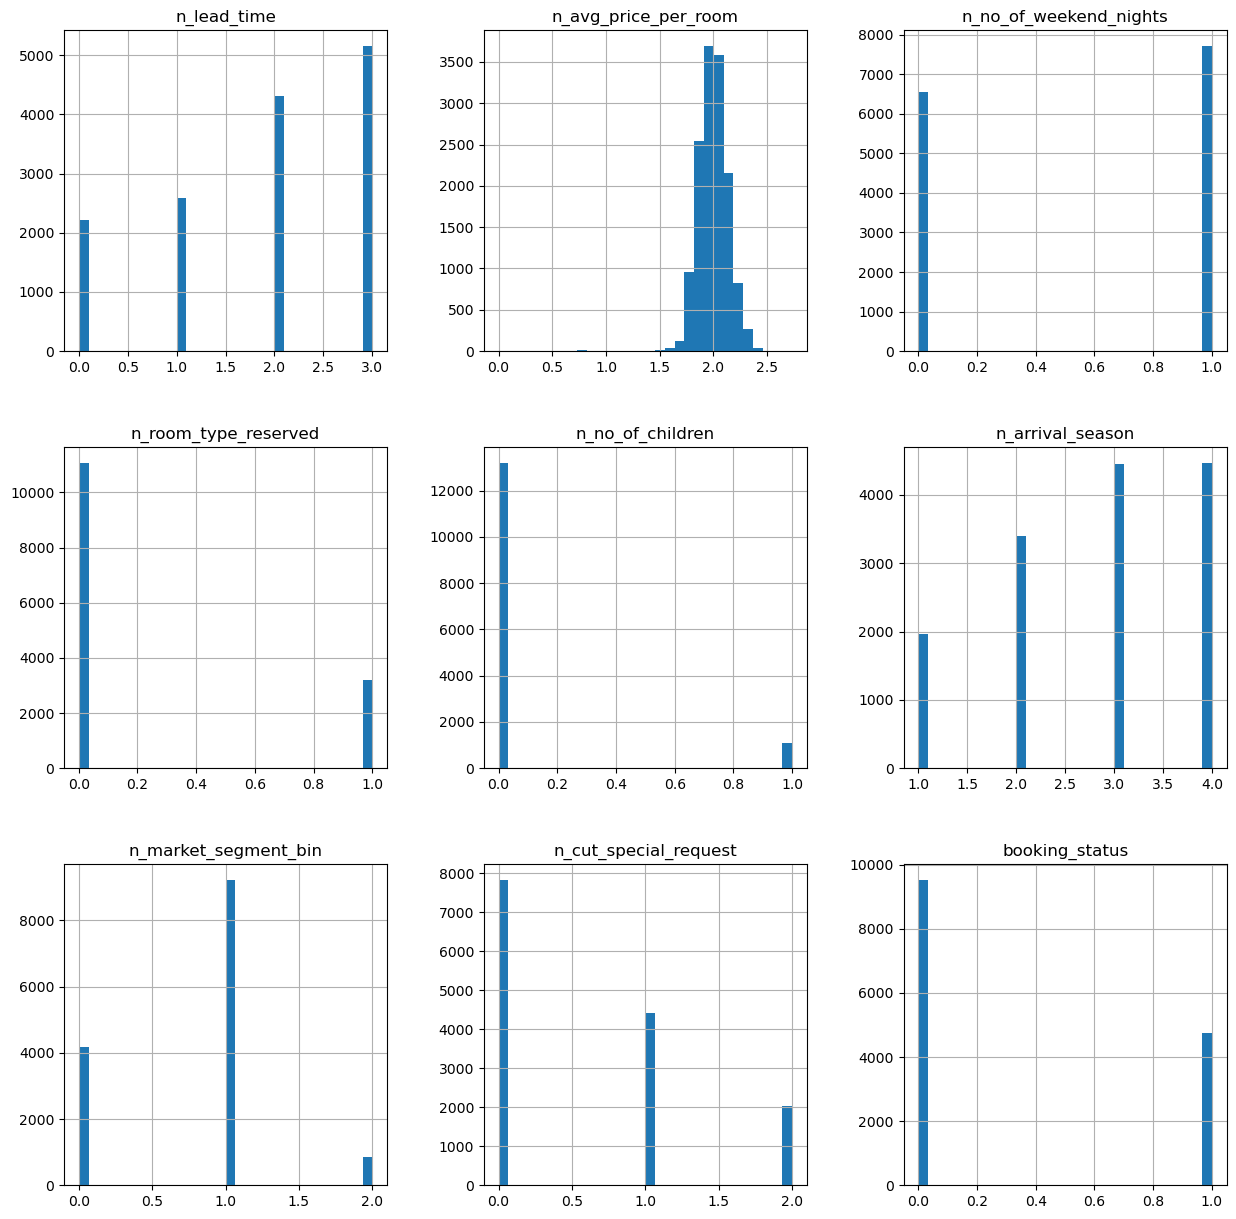

In [960]:
corr_view.hist(bins=30, figsize=(15,15))
plt.show()

In [961]:
corr_view["n_cut_special_request"]

6099     1
10601    0
13388    0
13645    2
13728    1
        ..
17791    2
8260     0
2874     0
7655     0
7239     0
Name: n_cut_special_request, Length: 14282, dtype: int64

Notiz:
lead_time hat die höchste Korrelation <br>
arrival_year wird vermutlich nur eine hohe Korrelation haben weil wir nur zwei Jahre haben, also ein bias - rausnehmen <br>
avg_price_per room würde ich drin lassen- evt gibt es noch eine kombi mit anderen Merkmalen die hilfreich wäre für eine besser Korrelation <br>
no of week nights würde ich noch drin lassen <br>
no of adulds auch und sonst nichts mehr das positiv korreliert

no of special requests sollte definitiv drin bleiben - ein binärmerkmal hat keine bessere korrelation ergeben aber könnte später für modelle evt besser sein zu verarbeiten z.B. Baum <br>
repeated guest hat auch eine hohe negative Korrelation aber der datensatz bietet nur wenige an die wiederholt haben, dass könnte dann auch eher ein bias StopIteration <br>
requiered car parking ist im Endefekt wie repeated guest - hat eine halbwegs hohe korrelation aber könnte auche ein Bias sein <br>



In [962]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Kategorische Attribute (werden one-hot encodiert)
cat_attribs = ["n_lead_time", "n_arrival_season", "n_market_segment_bin", "n_cut_special_request"]

# Numerische Attribute (werden skaliert)
num_attribs = ["n_avg_price_per_room"]

# Binäre Attribute (bleiben 0/1, werden durchgereicht)
bin_attribs = ["n_no_of_weekend_nights", "n_room_type_reserved", "n_no_of_children"]

# Pipelines
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# ColumnTransformer kombiniert alles
preprocess = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs),
    ("bin", "passthrough", bin_attribs)
])


In [963]:

df=binarize_features(df, ["no_of_weekend_nights","no_of_previous_cancellations","no_of_children","room_type_reserved"])

df["n_cut_special_request"] = pd.cut(df["no_of_special_requests"],  bins=[-0.5,0.5,1.5,np.inf], labels=[0,1,2]).astype(int)

# 0 | 1 | 2-4
df["n_market_segment_bin"] = pd.cut(df["market_segment_type"],bins=[-0.5, 0.5, 1.5, np.inf],labels=[0, 1, 2],include_lowest=True).astype(int)

# Winter, Frühling, Sommer, Herbst, Winter # 5 Intervalle → 5 Labels
df["n_arrival_season"] = pd.cut(df["arrival_month"],bins=[0,3,6,9,12],labels=[1, 2, 3, 4],include_lowest=True).astype(int)


#Entlastung avg_price_per_room
df["n_avg_price_per_room"] = np.log10(df["avg_price_per_room"])

In [964]:
target = "booking_status"
feature_cols = (
    ["n_avg_price_per_room"] +                                  # numerisch
    ["n_lead_time","n_arrival_season","n_market_segment_bin","n_cut_special_request"] +  # kateg.
    ["n_no_of_weekend_nights","n_room_type_reserved","n_no_of_children"]                  # binär
)

X = df[feature_cols].copy()
y = df[target].copy()

preprocess.fit_transform(X)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], shape=(17853, 18))

In [965]:
# Nach dem Fit/Transform:
X_prepared = preprocess.fit_transform(X)

# 1) Namen je Transform-Schritt holen – in DERSELBEN Reihenfolge wie im ColumnTransformer!
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_attribs)        # OHE-Namen (0/1)

num_names = num_attribs                                   # skalierte Numerik
bin_names = bin_attribs                                   # passthrough

# 2) Reihenfolge beachten: ("cat"), ("num"), ("bin")
all_feature_names = list(cat_names) + list(num_names) + list(bin_names)

# 3) DataFrame bauen
import pandas as pd
X_prepared_df = pd.DataFrame(X_prepared, columns=all_feature_names, index=X.index)


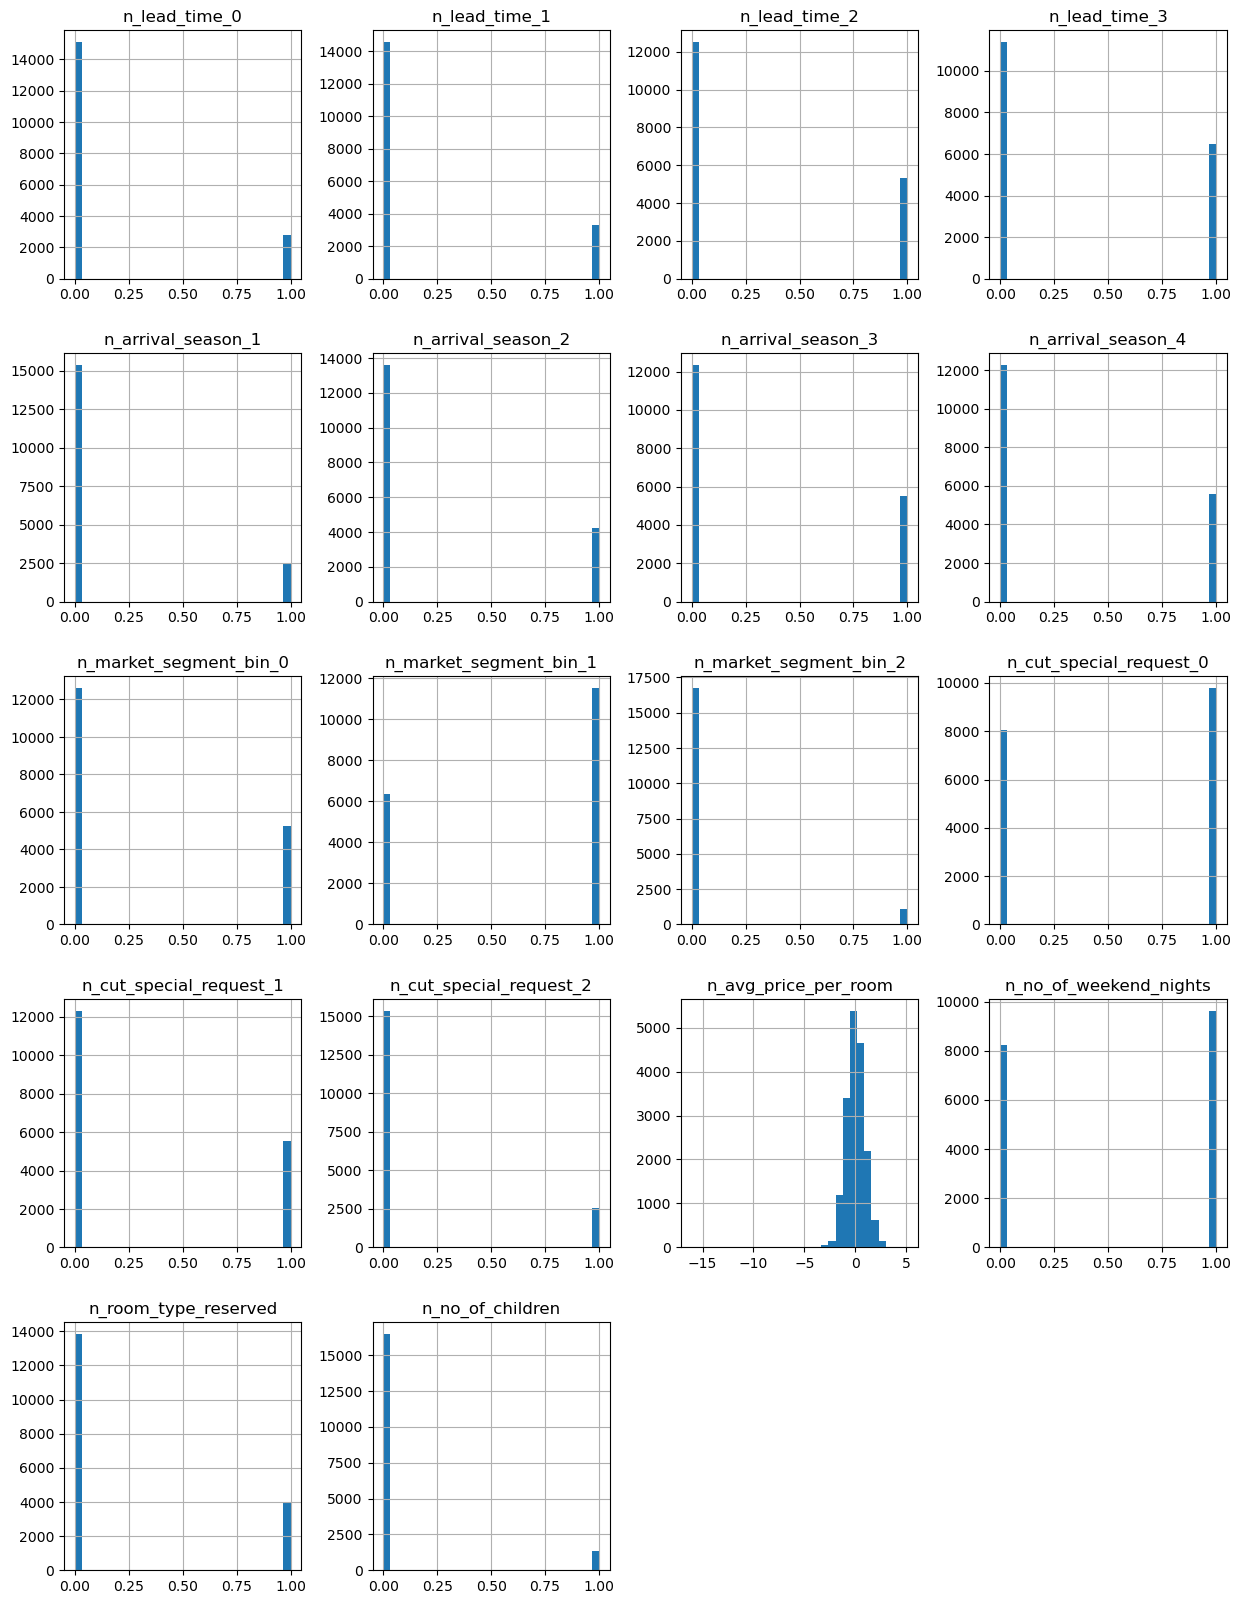

In [966]:
X_prepared_df.hist(bins=30, figsize=(15,20))
plt.show()

In [967]:
# 1) Train/Test-Split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

target = "booking_status"
feature_cols = (
    ["n_avg_price_per_room"] +                                  # numerisch
    ["n_lead_time","n_arrival_season","n_market_segment_bin","n_cut_special_request"] +  # kateg.
    ["n_no_of_weekend_nights","n_room_type_reserved","n_no_of_children"]                  # binär
)

X = df[feature_cols].copy()
y = df[target].copy()



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Modelle in je einer Pipeline (Preprocessing + Modell)
logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

rf_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42, class_weight="balanced"
    ))
])

# 3) Trainieren
logreg_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# 4) Bewerten
for name, pipe in [("LogReg", logreg_pipe), ("RandomForest", rf_pipe)]:
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(f"\n=== {name} ===")
    print("ROC-AUC :", roc_auc_score(y_test, y_proba).round(3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))




=== LogReg ===
ROC-AUC : 0.821
Confusion Matrix:
 [[1713  670]
 [ 293  895]]
              precision    recall  f1-score   support

           0      0.854     0.719     0.781      2383
           1      0.572     0.753     0.650      1188

    accuracy                          0.730      3571
   macro avg      0.713     0.736     0.715      3571
weighted avg      0.760     0.730     0.737      3571


=== RandomForest ===
ROC-AUC : 0.879
Confusion Matrix:
 [[2010  373]
 [ 325  863]]
              precision    recall  f1-score   support

           0      0.861     0.843     0.852      2383
           1      0.698     0.726     0.712      1188

    accuracy                          0.805      3571
   macro avg      0.780     0.785     0.782      3571
weighted avg      0.807     0.805     0.805      3571



In [968]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14282 entries, 6099 to 7239
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14282 non-null  int64  
 1   no_of_children                        14282 non-null  int64  
 2   no_of_weekend_nights                  14282 non-null  int64  
 3   no_of_week_nights                     14282 non-null  int64  
 4   type_of_meal_plan                     14282 non-null  int64  
 5   required_car_parking_space            14282 non-null  int64  
 6   room_type_reserved                    14282 non-null  int64  
 7   lead_time                             14282 non-null  int64  
 8   arrival_year                          14282 non-null  int64  
 9   arrival_month                         14282 non-null  int64  
 10  arrival_date                          14282 non-null  int64  
 11  market_segment_typ

In [973]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Pipeline: Preprocessing + Modell
rf_pipe = Pipeline([
    ("preprocess", preprocess),  # <- deine ColumnTransformer-Pipeline von oben
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparameter-Raum – schlank, aber aussagekräftig
param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 10],
    "clf__min_samples_leaf": [1, 5],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": [None, "balanced_subsample"]
}

# Stratified CV + GridSearch – Ziel: Precision maximieren
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    scoring="recall",#"precision",       # maximiert Precision der positiven Klasse (1 = Storno)
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best precision:", round(grid.best_score_, 3))

# Testevaluation
best_model = grid.best_estimator_
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Test ===")
print("Precision (pos=1):", round(precision_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best params: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
CV best precision: 0.822

=== Test ===
Precision (pos=1): 0.657
ROC-AUC: 0.881
Confusion Matrix:
 [[1871  512]
 [ 209  979]]
              precision    recall  f1-score   support

           0      0.900     0.785     0.838      2383
           1      0.657     0.824     0.731      1188

    accuracy                          0.798      3571
   macro avg      0.778     0.805     0.785      3571
weighted avg      0.819     0.798     0.803      3571



In [970]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Pipeline: Preprocessing + Klassifikator
logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(solver="liblinear", max_iter=2000))
])

# Parameter-Raum für GridSearch
param_grid_logreg = {
    "clf__penalty": ["l1", "l2"],           # Lasso vs. Ridge
    "clf__C": [0.01, 0.1, 1, 10],           # Inverser Regularisierungsstärke
    "clf__class_weight": [None, "balanced"]
}

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV mit Precision-Optimierung
grid_logreg = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="precision",     # Precision optimieren
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train
grid_logreg.fit(X_train, y_train)

print("Best params:", grid_logreg.best_params_)
print("CV best precision:", round(grid_logreg.best_score_, 3))

# Testbewertung
best_logreg = grid_logreg.best_estimator_
y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score

print("\n=== Test ===")
print("Precision (pos=1):", round(precision_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2'}
CV best precision: 0.706

=== Test ===
Precision (pos=1): 0.684
ROC-AUC: 0.818
Confusion Matrix:
 [[2089  294]
 [ 552  636]]
              precision    recall  f1-score   support

           0      0.791     0.877     0.832      2383
           1      0.684     0.535     0.601      1188

    accuracy                          0.763      3571
   macro avg      0.737     0.706     0.716      3571
weighted avg      0.755     0.763     0.755      3571



In [971]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ("logreg", grid_logreg.best_estimator_),   # beste LogReg aus Grid
        ("rf", grid.best_estimator_)              # bester RF aus Grid
    ],
    voting="soft",        # Wahrscheinlichkeiten mitteln
    weights=[1, 2]        # RF etwas mehr Gewicht geben
)

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score

print("Precision (Storno=1):", round(precision_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Precision (Storno=1): 0.762
ROC-AUC: 0.883
Confusion Matrix:
 [[2133  250]
 [ 388  800]]
              precision    recall  f1-score   support

           0      0.846     0.895     0.870      2383
           1      0.762     0.673     0.715      1188

    accuracy                          0.821      3571
   macro avg      0.804     0.784     0.792      3571
weighted avg      0.818     0.821     0.818      3571



In [972]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking = StackingClassifier(
    estimators=[
        ("logreg", grid_logreg.best_estimator_),
        ("rf", grid.best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=2000),
    passthrough=True,   # auch Originalfeatures werden genutzt
    n_jobs=-1
)

stacking.fit(X_train, y_train)

y_pred = stacking.predict(X_test)
y_proba = stacking.predict_proba(X_test)[:, 1]

print("Precision (Storno=1):", round(precision_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Precision (Storno=1): 0.761
ROC-AUC: 0.889
Confusion Matrix:
 [[2121  262]
 [ 355  833]]
              precision    recall  f1-score   support

           0      0.857     0.890     0.873      2383
           1      0.761     0.701     0.730      1188

    accuracy                          0.827      3571
   macro avg      0.809     0.796     0.801      3571
weighted avg      0.825     0.827     0.825      3571

